In [2]:
import json
import os
from collections import defaultdict
import traceback
from difflib import SequenceMatcher
import argparse

import fitz
from fitz import Rect
from PIL import Image
import xml.etree.ElementTree as ET
from xml.dom import minidom
# import editdistance
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pdf2image import convert_from_path
from PyPDF2 import PdfFileReader
import json
import numpy as np
import pdf2image
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
import copy
import re
import ast

In [3]:
def parse_html_table(table_html):
    try:
        tree = ET.fromstring(table_html)
    except Exception as e:
        print(e)
        return None
    
    table_cells = []
    
    occupied_columns_by_row = defaultdict(set)
    current_row = -1

    # Get all td tags
    stack = []
    stack.append((tree, False))
    while len(stack) > 0:
        current, in_header = stack.pop()

        if current.tag == 'tr':
            current_row += 1
            
        if current.tag == 'td' or current.tag =='th':
            if "colspan" in current.attrib:
                colspan = int(current.attrib["colspan"])
            else:
                colspan = 1
            if "rowspan" in current.attrib:
                rowspan = int(current.attrib["rowspan"])
            else:
                rowspan = 1
            row_nums = list(range(current_row, current_row + rowspan))
            try:
                max_occupied_column = max(occupied_columns_by_row[current_row])
                current_column = min(set(range(max_occupied_column+2)).difference(occupied_columns_by_row[current_row]))
            except:
                current_column = 0
            column_nums = list(range(current_column, current_column + colspan))
            for row_num in row_nums:
                occupied_columns_by_row[row_num].update(column_nums)
                
            cell_dict = dict()
            cell_dict['row_nums'] = row_nums
            cell_dict['column_nums'] = column_nums
            cell_dict['is_column_header'] = current.tag == 'th' or in_header
            table_cells.append(cell_dict)

        children = list(current)
        for child in children[::-1]:
            stack.append((child, in_header or current.tag == 'th' or current.tag == 'thead'))
    
    return table_cells

In [4]:
def create_table_dict(annotation_data):
    table_dict = {}
    table_dict['reject'] = []
    table_dict['fix'] = []
    
    html = ''.join(annotation_data['html']['structure']['tokens'])
    
    cells = parse_html_table(html)
    pdf_cells = annotation_data['html']['cells']
    
    # Make sure there are the same number of annotated HTML and PDF cells
    if not len(cells) == len(pdf_cells):
        table_dict['reject'].append("annotation mismatch")
    for cell, pdf_cell in zip(cells, pdf_cells):
        cell['json_text_content'] = ''.join(pdf_cell['tokens']).strip()
        if 'bbox' in pdf_cell:
            cell['pdf_text_tight_bbox'] = pdf_cell['bbox']
        else:
            cell['pdf_text_tight_bbox'] = []
        
    # Make sure no grid locations are duplicated
    grid_cell_locations = []
    for cell in cells:
        for row_num in cell['row_nums']:
            for column_num in cell['column_nums']:
                grid_cell_locations.append((row_num, column_num))
    if not len(grid_cell_locations) == len(set(grid_cell_locations)):
        table_dict['reject'].append("HTML overlapping grid cells")
        
    grid_cell_locations = set(grid_cell_locations)
                
    num_rows = max([max(cell['row_nums']) for cell in cells]) + 1
    num_columns = max([max(cell['column_nums']) for cell in cells]) + 1
    expected_num_cells = num_rows * num_columns
    actual_num_cells = len(grid_cell_locations)
        
    # Make sure all grid locations are present
    if not expected_num_cells == actual_num_cells:
        table_dict['reject'].append("HTML missing grid cells")
        
    table_dict['cells'] = cells
    table_dict['rows'] = {row_num: {'is_column_header': False} for row_num in range(num_rows)}
    table_dict['columns'] = {column_num: {} for column_num in range(num_columns)}
    
    return table_dict

In [5]:
def get_row_col_cell(num_rows, num_columns, table_dict):
    row_dict = {key : [] for key in range(num_rows)}
    col_dict = {key : [] for key in range(num_columns)}
    for cell in table_dict['cells']:
        if len(cell['row_nums']) == 1:
            idx_row = cell['row_nums'][0]
            # idx_col = cell['column_nums'][0]
            ori_bbox = cell['pdf_text_tight_bbox']
            if len(ori_bbox) == 0:
                continue
            x1, y1, x2, y2 = convert_coords(ori_bbox, pdf_height, pdf_width , tl_x, tl_y)
            row_dict[idx_row].append([x1, y1, x2, y2])
            # col_dict[idx_col].append([x1, y1, x2, y2])
    for cell in table_dict['cells']:
        if len(cell['column_nums']) == 1:
            # idx_row = cell['row_nums'][0]
            idx_col = cell['column_nums'][0]
            ori_bbox = cell['pdf_text_tight_bbox']
            if len(ori_bbox) == 0:
                continue
            x1, y1, x2, y2 = convert_coords(ori_bbox, pdf_height, pdf_width , tl_x, tl_y)
            # row_dict[idx_row].append([x1, y1, x2, y2])
            col_dict[idx_col].append([x1, y1, x2, y2])
    return  row_dict, col_dict

In [6]:
def get_row_bbox_final(row_dict, image_crop):
    row_bbox_final = []
    h,w,c = np.array(image_crop).shape
    # print(h,w,c)
    for row_element in row_dict:
        # print(row_element, row_dict[row_element])
        if len(row_dict[row_element]) == 0:
            continue
        row_element = np.array(row_dict[row_element])
        y1_min = np.min(row_element[:,1])+1
        y2_max = np.max(row_element[:,3])-1

        x1 = 0
        x2 = w
        row_bbox_final.append([x1, y1_min, x2, y2_max])
    return row_bbox_final

In [7]:
def get_col_bbox_final(col_dict, image_crop):
    col_bbox_final = []
    h,w,c = np.array(image_crop).shape
    for col_element in col_dict:
        if len(col_dict[col_element]) == 0:
            continue
        # print(col_element, col_dict[col_element])
        col_element = np.array(col_dict[col_element])
        x1_min = np.min(col_element[:,0])+1
        x2_max = np.max(col_element[:,2])-1
        # print(x1_min, x2_max)
        y1 = 0
        y2 = h
        col_bbox_final.append([x1_min, y1, x2_max, y2])
    return col_bbox_final

In [8]:
def get_row_bbox_midpoint(row_bbox_final , image_table_crop):
    row_mid = []
    for i in range(len(row_final)):
        if i == 0:
            pass
        else:
            try:
                row_tmp_1 = row_final[i-1]
                x1_1 , y1_1 , x2_1, y2_1 = row_tmp_1
                row_tmp_1 = row_final[i]
                x1_2 , y1_2 , x2_2, y2_2 = row_tmp_1

                mid_y = (y2_1 + y1_2)/2
                row_mid.append(mid_y)
            except:
                pass

    row_mid_bbox = []
    h,w,c = np.array(image_table_crop).shape
    for i , mid_point in enumerate(row_mid):
        if i == 0:
            x1 = 0
            x2 = w
            y1 = 0
            y2 = mid_point 
            row_mid_bbox.append([x1, y1, x2, y2])
        elif i == len(row_mid)-1:
            x1 = 0
            x2 = w
            y1 = mid_point 
            y2 = h
            row_mid_bbox.append([x1, y1, x2, y2])
        else:
            x1 = 0
            x2 = w
            y1 = mid_point 
            y2 = mid_point 
            row_mid_bbox.append([x1, y1, x2, y2])
    return row_mid_bbox


In [9]:
def get_col_bbox_midpoint(col_bbox_final , image_table_crop):
    col_mid = []
    for i in range(len(col_final)):
        if i == 0:
            pass
        else:
            try:
                col_tmp_1 = col_final[i-1]
                x1_1 , y1_1 , x2_1, y2_1 = col_tmp_1
                col_tmp_2 = col_final[i]
                x1_2 , y1_2 , x2_2, y2_2 = col_tmp_2

                mid_x = (x2_1 + x1_2)/2
                col_mid.append(mid_x)
            except:
                pass

    col_mid_bbox = []
    h,w,c = np.array(image_table_crop).shape
    for i , mid_point in enumerate(col_mid):
        if i == 0:
            x1 = 0
            x2 = mid_point
            y1 = 0
            y2 = h
            col_mid_bbox.append([x1, y1, x2, y2])
        elif i == len(col_mid)-1:
            x1 = mid_point
            x2 = w
            y1 = 0
            y2 = h
            col_mid_bbox.append([x1, y1, x2, y2])
        else:
            x1 = mid_point
            x2 = mid_point
            y1 = 0
            y2 = h
            col_mid_bbox.append([x1, y1, x2, y2])
    return col_mid_bbox

In [10]:
def remove_html_tags_in_text(table_dict):
    for cell in table_dict['cells']:
        cell['json_text_content'] = cell['json_text_content'].replace("<i>", " ")
        cell['json_text_content'] = cell['json_text_content'].replace("</i>", " ")
        cell['json_text_content'] = cell['json_text_content'].replace("<sup>", " ")
        cell['json_text_content'] = cell['json_text_content'].replace("</sup>", " ")
        cell['json_text_content'] = cell['json_text_content'].replace("<sub>", " ")
        cell['json_text_content'] = cell['json_text_content'].replace("</sub>", " ")
        cell['json_text_content'] = cell['json_text_content'].replace("  ", " ")
        cell['json_text_content'] = cell['json_text_content'].strip()


In [11]:
def remove_empty_columns(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    has_content_by_column = defaultdict(bool)
    for cell in table_dict['cells']:
        has_content = len(cell['json_text_content'].strip()) > 0
        for column_num in cell['column_nums']:
            has_content_by_column[column_num] = has_content_by_column[column_num] or has_content
    column_num_corrections = np.cumsum([int(not has_content_by_column[column_num]) for column_num in range(num_columns)]).tolist()
    
    # Delete cells in empty columns and renumber other cells
    cells_to_delete = []
    for cell in table_dict['cells']:
        new_column_nums = []
        for column_num in cell['column_nums']:
            if has_content_by_column[column_num]:
                new_column_nums.append(column_num - column_num_corrections[column_num])
        cell['column_nums'] = new_column_nums
        if len(new_column_nums) == 0:
            cells_to_delete.append(cell)
    for cell in cells_to_delete:
        table_dict['fix'].append('removed empty column')
        table_dict['cells'].remove(cell)
    
    columns = {}
    for column_num, has_content in has_content_by_column.items():
        if has_content:
            new_column_num = column_num - column_num_corrections[column_num]
            columns[new_column_num] = table_dict['columns'][column_num]
    table_dict['columns'] = columns
    

In [12]:
def merge_columns(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    co_occurrence_matrix = np.zeros((num_columns, num_columns))
    for cell in table_dict['cells']:
        for column_num1 in cell['column_nums']:
            for column_num2 in cell['column_nums']:
                if column_num1 >= column_num2:
                    continue
                co_occurrence_matrix[column_num1, column_num2] += len(cell['row_nums'])
                
    new_column_num = 0
    current_column_group = 0
    keep_column = [True]
    column_grouping = [current_column_group]
    for column_num in range(num_columns-1):
        if not co_occurrence_matrix[column_num, column_num+1] == num_rows:
            keep_column.append(True)
            new_column_num += 1
        else:
            table_dict['fix'].append('merged columns spanned together in every row')
            keep_column.append(False)
        column_grouping.append(new_column_num)

    for cell in table_dict['cells']:
        cell['column_nums'] = [column_grouping[column_num] for column_num in cell['column_nums'] if keep_column[column_num]]
        
    table_dict['columns'] = {column_grouping[column_num]: table_dict['columns'][column_num] for column_num in range(num_columns) if keep_column[column_num]}
    

In [13]:
def remove_empty_rows(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    has_content_by_row = defaultdict(bool)
    for cell in table_dict['cells']:
        has_content = len(cell['json_text_content'].strip()) > 0
        for row_num in cell['row_nums']:
            has_content_by_row[row_num] = has_content_by_row[row_num] or has_content
    row_num_corrections = np.cumsum([int(not has_content_by_row[row_num]) for row_num in range(num_rows)]).tolist()
    
    # Delete cells in empty rows and renumber other cells
    cells_to_delete = []
    for cell in table_dict['cells']:
        new_row_nums = []
        for row_num in cell['row_nums']:
            if has_content_by_row[row_num]:
                new_row_nums.append(row_num - row_num_corrections[row_num])
        cell['row_nums'] = new_row_nums
        if len(new_row_nums) == 0:
            cells_to_delete.append(cell)
    for cell in cells_to_delete:
        table_dict['fix'].append('removed empty row')
        table_dict['cells'].remove(cell)
    
    rows = {}
    for row_num, has_content in has_content_by_row.items():
        if has_content:
            new_row_num = row_num - row_num_corrections[row_num]
            rows[new_row_num] = table_dict['rows'][row_num]
    table_dict['rows'] = rows

In [14]:
def merge_rows(table_dict):
    num_rows = len(table_dict['rows'])
    num_columns = len(table_dict['columns'])
    co_occurrence_matrix = np.zeros((num_rows, num_rows))
    for cell in table_dict['cells']:
        for row_num1 in cell['row_nums']:
            for row_num2 in cell['row_nums']:
                if row_num1 >= row_num2:
                    continue
                co_occurrence_matrix[row_num1, row_num2] += len(cell['column_nums'])
                
    new_row_num = 0
    current_row_group = 0
    keep_row = [True]
    row_grouping = [current_row_group]
    for row_num in range(num_rows-1):
        if not co_occurrence_matrix[row_num, row_num+1] == num_columns:
            keep_row.append(True)
            new_row_num += 1
        else:
            table_dict['fix'].append('merged rows spanned together in every column')
            keep_row.append(False)
        row_grouping.append(new_row_num)

    for cell in table_dict['cells']:
        cell['row_nums'] = [row_grouping[row_num] for row_num in cell['row_nums'] if keep_row[row_num]]
        
    table_dict['rows'] = {row_grouping[row_num]: table_dict['rows'][row_num] for row_num in range(num_rows) if keep_row[row_num]} 
   

In [15]:
def convert_coords(bbox, pdf_height, pdf_width , tl_x, tl_y):
    x1 = int(bbox[0] -tl_x)
    y1 = int(float(pdf_height) - bbox[3] -tl_y )
    x2 = int(bbox[2] -tl_x)
    y2 = int(float(pdf_height) - bbox[1] -tl_y )
    return x1, y1, x2, y2


In [16]:
def correct_header(table_dict, assume_header_if_more_than_two_columns=True):
    num_columns = len(table_dict['columns'])
    num_rows = len(table_dict['rows'])
    
    if num_columns < 2 or num_rows < 1:
        table_dict['reject'].append("small table")
        
    #---DETERMINE FULL EXTENT OF COLUMN HEADER
    # - Each of the below steps determines different rows that must be in the column header.
    # - The final column header includes all rows that are originally annotated as being in the column
    #   header plus any additional rows determined to be in the column header by the following steps.
    
    table_has_column_header = False
    
    # First determine if there is definitely a column header. Cases:
    
    # 1. We specify that we want to assume there is one for all tables with more than two columns:
    if assume_header_if_more_than_two_columns and num_columns > 2:
        table_has_column_header = True
    
    # 2. An annotator says there is
    if not table_has_column_header:
        header_rows = [row_num for row_num, row in table_dict['rows'].items() if row['is_column_header']]
        if 0 in header_rows:
            table_has_column_header = True
        
    # 3. The cell occupying the first row and column is blank
    if not table_has_column_header:
        for cell in table_dict['cells']:
            if 0 in cell['column_nums'] and 0 in cell['row_nums'] and len(cell['json_text_content'].strip()) == 0:
                table_has_column_header = True
                break
    
    # 4. There is a horizontal spanning cell in the first row
    if not table_has_column_header:
        for cell in table_dict['cells']:
            if 0 in cell['row_nums'] and len(cell['column_nums']) > 1:
                table_has_column_header = True
                break
                
    # 5. Particular words or phrases appear in the first row 
    if not table_has_column_header:
        for cell in table_dict['cells']:
            if 0 in cell['row_nums'] and 0 in cell['column_nums'] and 'Number' in cell['json_text_content']:
                table_dict['fix'].append("two column header: Number")
                table_has_column_header = True
                break
            if 0 in cell['row_nums'] and 1 in cell['column_nums'] and 'Page' in cell['json_text_content']:
                table_dict['fix'].append("two column header: Page")
                table_has_column_header = True
                break
            if 0 in cell['row_nums'] and 'in thousands' in cell['json_text_content'].lower():
                table_dict['fix'].append("two column header: in thousands")
                table_has_column_header = True
                break
            if 0 in cell['row_nums'] and 'in millions' in cell['json_text_content'].lower():
                table_dict['fix'].append("two column header: in millions")
                table_has_column_header = True
                break
            if 0 in cell['row_nums'] and 'Measurement' in cell['json_text_content']:
                table_dict['fix'].append("two column header: Measurement")
                table_has_column_header = True
                break
            if 0 in cell['row_nums'] and 'Period' in cell['json_text_content']:
                table_dict['fix'].append("two column header: Period")
                table_has_column_header = True
                break

    # Then determine if the column header needs to be extended past its current annotated extent.
    #  1. A header that already is annotated in at least one row continues at least until each column
    #     has a cell occupying only that column
    #  2. A header with a column with a blank cell must continue at least as long as the blank cells continue
    #     (unless rule #1 is satisfied and a possible projected row header is reached?)
    if table_has_column_header:
        first_column_filled_by_row = defaultdict(bool)
        for cell in table_dict['cells']:
            if 0 in cell['column_nums']:
                if len(cell['json_text_content']) > 0:
                    for row_num in cell['row_nums']:
                        first_column_filled_by_row[row_num] = True
        
        first_single_node_row_by_column = defaultdict(lambda: len(table_dict['rows'])-1)
        for cell in table_dict['cells']:
            if len(cell['column_nums']) == 1:
                first_single_node_row_by_column[cell['column_nums'][0]] = min(first_single_node_row_by_column[cell['column_nums'][0]],
                                                                               max(cell['row_nums']))
                
        first_filled_single_node_row_by_column = defaultdict(lambda: len(table_dict['rows'])-1)
        for cell in table_dict['cells']:
            if len(cell['column_nums']) == 1 and len(cell['json_text_content'].strip()) > 0:
                first_filled_single_node_row_by_column[cell['column_nums'][0]] = min(first_filled_single_node_row_by_column[cell['column_nums'][0]],
                                                                               max(cell['row_nums']))
                
        first_filled_cell_by_column = defaultdict(lambda: len(table_dict['rows'])-1)
        for cell in table_dict['cells']:
            if len(cell['json_text_content']) > 0:
                min_row_num = min(cell['row_nums'])
                for column_num in cell['column_nums']:
                    first_filled_cell_by_column[column_num] = min(first_filled_cell_by_column[column_num],
                                                                  min_row_num)
                    
        projected_row_header_rows = identify_projected_row_headers(table_dict)
        if 0 in projected_row_header_rows:
            table_dict['reject'].append("bad projected row header")
        
        # Header must continue until at least this row
        minimum_grid_cell_single_node_row = max(first_single_node_row_by_column.values())
        
        # Header can stop prior to the first of these rows that occurs after the above row
        minimum_first_body_row = min(num_rows-1, max(first_filled_cell_by_column.values()))
        
        # Determine the max row for which a column N has been single and filled but column N+1 has not
        minimum_all_following_filled = -1
        for row_num in range(num_rows):
            for column_num1 in range(num_columns-1):
                for column_num2 in range(column_num1+1, num_columns):
                    if (first_filled_single_node_row_by_column[column_num2] > row_num
                        and first_filled_single_node_row_by_column[column_num1] < first_filled_single_node_row_by_column[column_num2]):
                        minimum_all_following_filled = row_num + 1

        if len(projected_row_header_rows) > 0:
            minimum_projected_row_header_row = min(projected_row_header_rows)
        else:
            minimum_projected_row_header_row = num_rows

        first_possible_last_header_row = minimum_first_body_row - 1
                    
        last_header_row = max(minimum_all_following_filled,
                              minimum_grid_cell_single_node_row,
                              first_possible_last_header_row)
        
        x = last_header_row
        while(last_header_row < num_rows and not first_column_filled_by_row[last_header_row+1]):
            last_header_row += 1            
        
        if minimum_projected_row_header_row <= last_header_row:
            last_header_row = minimum_projected_row_header_row - 1
        
        for cell in table_dict['cells']:
            if max(cell['row_nums']) <= last_header_row:
                cell['is_column_header'] = True
        
        for row_num, row in table_dict['rows'].items():
            if row_num <= last_header_row:
                row['is_column_header'] = True
    
    if not table_has_column_header and num_columns == 2:
        keep_table = False
        for cell in table_dict['cells']:
            if 0 in cell['row_nums'] and len(cell['json_text_content']) > 60:
                keep_table = True
                table_dict['fix'].append("two column no header: long text")
                break
            if 0 in cell['row_nums'] and 1 in cell['column_nums'] and re.match('^[0-9,%\.\$ -]+$', cell['json_text_content']):
                keep_table = True
                table_dict['fix'].append("two column no header: numeric")
                break
        
        if not keep_table:
            table_dict['reject'].append("ambiguous header")

In [17]:
def annotate_projected_row_headers(table_dict):    
    num_cols = len(table_dict['columns'])
    projected_row_header_rows = identify_projected_row_headers(table_dict)

    cells_to_remove = []
    for cell in table_dict['cells']:
        if len(set(cell['row_nums']).intersection(projected_row_header_rows)) > 0:
            if len(cell['json_text_content']) > 0:
                cell['column_nums'] = list(range(num_cols))
                cell['is_projected_row_header'] = True
            else:
                cells_to_remove.append(cell) # Consolidate blank cells after the first cell into the projected row header
        else:
            cell['is_projected_row_header'] = False

    for cell in cells_to_remove:
        table_dict['fix'].append('merged projected row header')
        table_dict['cells'].remove(cell)
        
    for row_num, row in table_dict['rows'].items():
        if row_num in projected_row_header_rows:
            row['is_projected_row_header'] = True
        else:
            row['is_projected_row_header'] = False
            
    # Delete projected row headers in last rows
    num_rows = len(table_dict['rows'])
    row_nums_to_delete = []
    for row_num in range(num_rows-1, -1, -1):
        if table_dict['rows'][row_num]['is_projected_row_header']:
            row_nums_to_delete.append(row_num)
        else:
            break
            
    if len(row_nums_to_delete) > 0:
        for row_num in row_nums_to_delete:
            del table_dict['rows'][row_num]
            table_dict['fix'].append('removed projected row header at bottom of table')
            for cell in table_dict['cells'][:]:
                if row_num in cell['row_nums']:
                    table_dict['cells'].remove(cell)

In [18]:
def identify_projected_row_headers(table_dict):
    num_cols = len(table_dict['columns'])
    cells_with_text_count_by_row = defaultdict(int)
    all_cells_in_row_only_in_one_row_by_row = defaultdict(lambda: True)
    has_first_column_cell_with_text_by_row = defaultdict(bool)
    for cell in table_dict['cells']:
        if len(cell['json_text_content']) > 0:
            for row_num in cell['row_nums']:
                cells_with_text_count_by_row[row_num] += 1

            if 0 in cell['column_nums']:
                has_first_column_cell_with_text_by_row[row_num] = True

        one_row_only = len(cell['row_nums']) == 1
        for row_num in cell['row_nums']:
            all_cells_in_row_only_in_one_row_by_row[row_num] = all_cells_in_row_only_in_one_row_by_row[row_num] and one_row_only

    projected_row_header_rows = set()
    for row_num, row in table_dict['rows'].items():
        if (not row['is_column_header'] and cells_with_text_count_by_row[row_num] == 1
                and all_cells_in_row_only_in_one_row_by_row[row_num]
                and has_first_column_cell_with_text_by_row[row_num]):
            projected_row_header_rows.add(row_num)
            
    return projected_row_header_rows

In [19]:
def merge_group(table_dict, group):
    cells_to_delete = []
    if len(group) == 1:
        return table_dict
    group = sorted(group, key=lambda k: min(k['row_nums'])) 
    cell = group[0]
    try:
        cell_text_rect = Rect(cell['pdf_text_tight_bbox'])
    except:
        cell_text_rect = Rect()
    for cell2 in group[1:]:
        cell['row_nums'] = list(set(sorted(cell['row_nums'] + cell2['row_nums'])))
        cell['column_nums'] = list(set(sorted(cell['column_nums'] + cell2['column_nums'])))
        cell['json_text_content'] = (cell['json_text_content'].strip() + " " + cell2['json_text_content'].strip()).strip()
        try:
            cell2_text_rect = Rect(cell2['pdf_text_tight_bbox'])
        except:
            cell2_text_rect = Rect()
        cell_text_rect = cell_text_rect.include_rect(list(cell2_text_rect))
        if cell_text_rect.get_area() == 0:
            cell['pdf_text_tight_bbox'] = []
        else:
            cell['pdf_text_tight_bbox'] = list(cell_text_rect)
        cell['is_projected_row_header'] = False
        cells_to_delete.append(cell2)
        
    try:
        for cell in cells_to_delete:
            table_dict['cells'].remove(cell)
            table_dict['fix'].append('merged oversegmented spanning cell')
    except:
        table_dict['reject'].append("ambiguous spanning cell")

In [20]:
def canonicalize(table_dict):
    # Preprocessing step: Split every blank spanning cell in the column header into blank grid cells.
    cells_to_delete = []
    try:
        for cell in table_dict['cells']:
            if (cell['is_column_header'] and len(cell['json_text_content'].strip()) == 0
                    and (len(cell['column_nums']) > 1 or len(cell['row_nums']) > 1)):
                cells_to_delete.append(cell)
                # Split this blank spanning cell into blank grid cells
                for column_num in cell['column_nums']:
                    for row_num in cell['row_nums']:
                        new_cell = {'json_text_content': '',
                                    'column_nums': [column_num],
                                    'row_nums': [row_num],
                                    'is_column_header': cell['is_column_header'],
                                    'pdf_text_tight_bbox': [],
                                    'is_projected_row_header': False}
                        table_dict['cells'].append(new_cell)
    except:
        print(traceback.format_exc())
    for cell in cells_to_delete:
        table_dict['cells'].remove(cell)
        
    # Index cells by row-column position
    cell_grid_index = {}
    for cell in table_dict['cells']:
        for column_num in cell['column_nums']:
            for row_num in cell['row_nums']:
                cell_grid_index[(row_num, column_num)] = cell
        
    # Go bottom up, try to extend non-blank cells up to absorb blank cells
    header_groups = []
    for cell in table_dict['cells']:
        if not cell['is_column_header'] or len(cell['json_text_content']) == 0:
            continue
        header_group = [cell]
        next_row_num = min(cell['row_nums']) - 1
        for row_num in range(next_row_num, -1, -1):
            all_are_blank = True
            for column_num in cell['column_nums']:
                cell2 = cell_grid_index[(row_num, column_num)]
                all_are_blank = all_are_blank and len(cell2['json_text_content']) == 0
            if all_are_blank:
                for column_num in cell['column_nums']:
                    header_group.append(cell_grid_index[(row_num, column_num)])
            else:
                break # Stop looking; must be contiguous
        if len(header_group) > 1:
            header_groups.append(header_group)
    for group in header_groups:
        merge_group(table_dict, group)
            
    # Index cells by row-column position
    cell_grid_index = {}
    for cell in table_dict['cells']:
        for column_num in cell['column_nums']:
            for row_num in cell['row_nums']:
                cell_grid_index[(row_num, column_num)] = cell
                
    num_rows = len(table_dict['rows'])
    # Go top down, try to extend non-blank cells down to absorb blank cells
    header_groups = []
    for cell in table_dict['cells']:
        if not cell['is_column_header'] or len(cell['json_text_content']) == 0:
            continue
        header_group = [cell]
        next_row_num = max(cell['row_nums']) + 1
        for row_num in range(next_row_num, num_rows):
            if not table_dict['rows'][row_num]['is_column_header']:
                break
            all_are_blank = True
            for column_num in cell['column_nums']:
                cell2 = cell_grid_index[(row_num, column_num)]
                all_are_blank = all_are_blank and len(cell2['json_text_content']) == 0
            if all_are_blank:
                for column_num in cell['column_nums']:
                    header_group.append(cell_grid_index[(row_num, column_num)])
            else:
                break # Stop looking; must be contiguous
        if len(header_group) > 1:
            header_groups.append(header_group)
    for group in header_groups:
        merge_group(table_dict, group)
    
    # Index cells by row-column position
    cell_grid_index = {}
    for cell in table_dict['cells']:
        for column_num in cell['column_nums']:
            for row_num in cell['row_nums']:
                cell_grid_index[(row_num, column_num)] = cell
        
    # Go top down, merge any neighboring cells occupying the same columns, whether they are blank or not
    header_groups_by_row_column = defaultdict(list)
    header_groups = []
    do_full_break = False
    for row_num in table_dict['rows']:
        for column_num in table_dict['columns']:
            cell = cell_grid_index[(row_num, column_num)]
            if not cell['is_column_header']:
                do_full_break = True
                break
            if len(header_groups_by_row_column[(row_num, column_num)]) > 0:
                continue
            if not row_num == min(cell['row_nums']) and column_num == min(cell['column_nums']):
                continue
            # Start new header group
            header_group = [cell]
            next_row_num = max(cell['row_nums']) + 1
            while next_row_num < num_rows:
                cell2 = cell_grid_index[(next_row_num, column_num)]
                if cell2['is_column_header'] and set(cell['column_nums']) == set(cell2['column_nums']):
                    header_group.append(cell2)
                    for row_num2 in cell2['row_nums']:
                        for column_num2 in cell2['column_nums']:
                            header_groups_by_row_column[(row_num2, column_num2)] = header_group
                else:
                    break
                next_row_num = max(cell2['row_nums']) + 1
            for row_num2 in cell['row_nums']:
                for column_num2 in cell['column_nums']:
                    header_groups_by_row_column[(row_num2, column_num2)] = header_group
            if len(header_group) > 1:
                header_groups.append(header_group)
        if do_full_break:
            break
    for group in header_groups:
        merge_group(table_dict, group)
        
    # Merge spanning cells in the row header
    merge_spanning_cells_in_first_column(table_dict)

In [21]:
def merge_spanning_cells_in_first_column(table_dict):
    numeric_count_by_column = defaultdict(int)
    alpha_count_by_column = defaultdict(int)
    for cell in table_dict['cells']:
        if cell['is_column_header'] or cell['is_projected_row_header']:
            continue
        numeric_count = sum([1 for ch in cell['json_text_content'] if ch.isnumeric()])
        alpha_count = sum([1 for ch in cell['json_text_content'] if ch.isalpha()])
        for column_num in cell['column_nums']:
            numeric_count_by_column[column_num] += numeric_count
            alpha_count_by_column[column_num] += alpha_count
    if not alpha_count_by_column[1] > numeric_count_by_column[1]:
        return

    first_column_cells = [cell for cell in table_dict['cells'] if 0 in cell['column_nums']]
    first_column_cells = sorted(first_column_cells, key=lambda item: max(item['row_nums']))
    
    current_filled_cell = None
    groups = defaultdict(list)
    group_num = -1
    for cell in first_column_cells:
        if len(cell['json_text_content']) > 0:
            group_num += 1
        if group_num >= 0:
            groups[group_num].append(cell)
        
    for group_num, group in groups.items():
        if len(group) > 1 and not group[0]['is_projected_row_header'] and not group[0]['is_column_header']:
            merge_group(table_dict, group)

In [22]:
def change_bbox_to_new_size(image_crop, cell_list , size = 512):
    return_list =  []
    h,w,c = image_crop.shape
    # print(h,w,c)
    image_resize = image_resize = cv2.resize(image_crop, (size, size))
    for bbox in cell_list:
        row_idx, col_idx, x1, y1, x2, y2 = bbox
        x1_new = int(x1/w*size)
        y1_new = int(y1/h*size)
        x2_new = int(x2/w*size)
        y2_new = int(y2/h*size)
        new_bbox = [row_idx, col_idx , x1_new, y1_new, x2_new, y2_new]
        return_list.append(new_bbox)
    return image_resize , return_list

In [23]:
def pad_array_row(x):
    padded = np.pad(x, ((1,0), (0,0)), mode= 'constant', constant_values= 0)
    return padded
def pad_array_col(x):
    padded = np.pad(x, ((0,0), (1,0)), mode= 'constant', constant_values= 0)
    return padded

In [24]:
def get_matrix_col(table_dict, num_rows, num_columns):
    matrix_col = np.zeros(shape=(num_rows, num_columns-1), dtype=int)
    for cell in table_dict['cells']:
        if len(cell['column_nums']) > 1:
            idx_row_list = cell['row_nums']
            idx_col_list = cell['column_nums']
            for idx_row in idx_row_list:
                for i , idx_col in enumerate(idx_col_list):
                    if i == 0:
                        pass
                    else:
                        matrix_col[idx_row, idx_col-1] = 1
    final_matrix_col = pad_array_col(matrix_col)
    return final_matrix_col

In [25]:
def get_matrix_row(table_dict, num_rows, num_columns):
    matrix_row = np.zeros(shape = (num_rows-1, num_columns), dtype=int)
    for cell in table_dict['cells']:
        if len(cell['row_nums']) > 1:
            idx_row_list = cell['row_nums']
            idx_col_list = cell['column_nums']
            for idx_col in idx_col_list:
                for i , idx_row in enumerate(idx_row_list):
                    if i == 0:
                        pass
                    else:
                        matrix_row[idx_row-1, idx_col] = 1
    final_matrix_row = pad_array_row(matrix_row)
    return final_matrix_row

In [26]:
def table_dict_final(idx):
    data_detection = json.loads(structure_lines[idx])
    table_dict = create_table_dict(data_detection)
    remove_html_tags_in_text(table_dict)
    for cell in table_dict['cells']:
        if 0 in cell['row_nums'] and len(cell['row_nums']) > 2 and len(cell['json_text_content'].strip()) > 0:
            table_dict['reject'].append("overmerged cells")
    merged = False
    debug = False

    remove_empty_columns(table_dict)
    merge_columns(table_dict)      
    remove_empty_rows(table_dict)
    merge_rows(table_dict)

    for cell in table_dict['cells']:
        if cell['json_text_content'] in ['¢', '$']:
            table_dict['reject'].append("oversegmented columns")
    total_characters_by_column = defaultdict(int)
    has_small_filled_cell_by_column = defaultdict(int)
    for cell in table_dict['cells']:
        if len(cell['column_nums']) == 1:
            column_num = cell['column_nums'][0]
            total_characters_by_column[column_num] += len(cell['json_text_content'])
            if (len(cell['json_text_content']) > 0
                and (len(cell['json_text_content']) < 2
                        or (len(cell['json_text_content']) < 4
                            and cell['json_text_content'][0] == '('))):
                has_small_filled_cell_by_column[column_num] = True
    num_rows = len(table_dict['rows'])
    for column_num, total in total_characters_by_column.items():
        if total < num_rows and has_small_filled_cell_by_column[column_num]:
            table_dict['reject'].append("oversegmented columns")

    correct_header(table_dict, assume_header_if_more_than_two_columns=True)
    annotate_projected_row_headers(table_dict)

    canonicalize(table_dict)
    remove_empty_columns(table_dict)
    merge_columns(table_dict)      
    remove_empty_rows(table_dict)
    merge_rows(table_dict)
    num_columns = len(table_dict['columns'])
    for row_num, row in table_dict['rows'].items():
        if row['is_column_header'] and (row_num > 4 or row_num >= num_columns-1):
            table_dict['reject'].append("oversized header")
    return table_dict

In [27]:
def get_col_mid_point(col_mid_line , image_table_crop):
    col_point_list =[]
    h,w,c = np.array(image_table_crop).shape
    if len(col_mid_line) == 1:
        x1 , y1 , x2, y2 = col_mid_line[0]
        col_point_list.append(x1)
        col_point_list.append(x2)
        col_point_list.append(w)
        return col_point_list
    for idx , bbox in enumerate(col_mid_line):
        if idx == 0:
            x1 , y1 , x2, y2 = bbox
            col_point_list.append(x1)
            col_point_list.append(x2)
        elif (idx == len(col_mid_line)-1):
            x1 , y1 , x2, y2 = bbox
            col_point_list.append(x1)
            col_point_list.append(w)       
        else:
            x1 , y1 , x2, y2 = bbox
            col_point_list.append(x1)    
    return col_point_list

In [28]:
def get_row_mid_pont(row_mid_line , image_table_crop):
    row_point_list = []
    h,w,c = np.array(image_table_crop).shape
    if len(row_mid_line) == 1 :
        x1 , y1 , x2, y2 = row_mid_line[0]
        row_point_list.append(x1)
        row_point_list.append(x2)
        row_point_list.append(h)
    for idx , bbox in enumerate(row_mid_line):
        if idx == 0:
            x1 , y1 , x2, y2 = bbox
            row_point_list.append(y1)
            row_point_list.append(y2)
        elif (idx == len(row_mid_line)-1):
            x1 , y1 , x2, y2 = bbox
            row_point_list.append(y1)
            row_point_list.append(h)
        else:
            x1 , y1 , x2, y2 = bbox
            row_point_list.append(y1)   
    return row_point_list

In [29]:
def get_bbox_cell(row_point_list,col_point_list ):
    bbox_cell_list = []
    for row_idx in range(1,len(row_point_list)):
        y1_row = row_point_list[row_idx-1]
        y2_row = row_point_list[row_idx]
        for col_idx in range(1,len(col_point_list)):
            x1_col = col_point_list[col_idx-1]
            x2_col = col_point_list[col_idx]

            bbox = [(row_idx-1), (col_idx-1), x1_col, y1_row, x2_col, y2_row]
            bbox_cell_list.append(bbox)
    return bbox_cell_list


In [30]:
def generate_html_table(data: list) -> str:
    table = "<table border='1'>\n"

    # Find max row and col to determine table size
    max_row = max(
        max(item['row']) if isinstance(item['row'], list) else item['row']
        for item in data
    )
    max_col = max(
        max(item['col']) if isinstance(item['col'], list) else item['col']
        for item in data
    )

    # Create an empty table structure
    table_structure = [['' for _ in range(max_col + 1)] for _ in range(max_row + 1)]
    span_map = {}

    # Populate the table with data
    for item in data:
        try:
          rows = item['row'] if isinstance(item['row'], list) else [item['row']]
          cols = item['col'] if isinstance(item['col'], list) else [item['col']]
          content = item['content']

          span_map[(rows[0], cols[0])] = (len(rows), len(cols))
          table_structure[rows[0]][cols[0]] = content
        except:
          pass

        # Mark spanned cells
        for r in rows:
            for c in cols:
                if (r, c) != (rows[0], cols[0]):
                    table_structure[r][c] = None

    # Generate HTML table rows
    for r, row in enumerate(table_structure):
        table += "  <tr>\n"
        for c, cell in enumerate(row):
            if cell is not None:
                rowspan, colspan = span_map.get((r, c), (1, 1))
                rowspan_attr = f" rowspan='{rowspan}'" if rowspan > 1 else ""
                colspan_attr = f" colspan='{colspan}'" if colspan > 1 else ""
                table += f"    <td{rowspan_attr}{colspan_attr}>{cell}</td>\n"
        table += "  </tr>\n"

    table += "</table>"
    return table

In [31]:
def gen_table_dict_for_html(table_dict):
    table_dict_html = []
    for cell in table_dict:
        cell_dict = dict()
        row_cnt = cell['row_nums']
        col_cnt = cell['column_nums']
        cell_dict['row'] = row_cnt
        cell_dict['col'] = col_cnt
        content = cell['json_text_content']        
        if not len(content):
            content = ' '
        cell_dict['content'] = content
        table_dict_html.append(cell_dict)
    return table_dict_html
        

In [33]:
data_fintabnet_path =  "D:/fintabnet/fintabnet/"
subdir = "test"
structure_filename  = "FinTabNet_1.0.0_cell_" + subdir + ".jsonl"
detection_filename = "FinTabNet_1.0.0_table_" + subdir +  ".jsonl"
structure_filepath = os.path.join(data_fintabnet_path, structure_filename)
detection_filepath = os.path.join(data_fintabnet_path, detection_filename)
print(f'detection_filepath :{structure_filepath}')
with open(structure_filepath, "r") as f:
    structure_lines = f.readlines()

detection_filepath :D:/fintabnet/fintabnet/FinTabNet_1.0.0_cell_test.jsonl


In [ ]:
# i = 80000
# print(f'idx : {i}')
# data_detection = json.loads(structure_lines[i])
# table_dict = table_dict_final(i)
# file_name= data_detection['filename']
# print(file_name)
# pdf_filepath = data_fintabnet_path + "pdf/" + file_name
# pdf_page = PdfFileReader(pdf_filepath).getPage(0)
# pdf_shape = pdf_page.mediaBox
# pdf_height = pdf_shape[3]-pdf_shape[1]
# pdf_width = pdf_shape[2]-pdf_shape[0]
# converted_images = convert_from_path(pdf_filepath, size=(pdf_width, pdf_height))
# img = converted_images[0]
# # print(pdf_height, pdf_width)
# table_box = data_detection['bbox']
# # print(f'1st : {table_box}')
# # print(f'pdf_height {pdf_height}')
# tl_x =              (table_box[0])
# tl_y = float(pdf_height) - (table_box[3]) 
# br_x =              (table_box[2])
# br_y = float(pdf_height) - (table_box[1])
# # print(tl_x, tl_y, br_x, br_y)
# img_array = np.array(img)
# page_image = Image.fromarray(img_array)
# image_table_crop = page_image.crop((int(tl_x), int(tl_y), int(br_x), int(br_y)))
# # plt.imshow(image_table_crop)
# # plt.show()
# num_rows = max([max(cell['row_nums']) for cell in table_dict['cells']]) + 1
# num_columns = max([max(cell['column_nums']) for cell in table_dict['cells']]) + 1
# row_dict, col_dict = get_row_col_cell(num_rows, num_columns, table_dict)
# row_final = get_row_bbox_final(row_dict, image_table_crop)
# col_final = get_col_bbox_final(col_dict, image_table_crop)


# row_mid_line = get_row_bbox_midpoint(row_final , image_table_crop)
# col_mid_line = get_col_bbox_midpoint(col_final , image_table_crop)
# row_point_list = get_row_mid_pont(row_mid_line , image_table_crop)
# col_point_list = get_col_mid_point(col_mid_line , image_table_crop)
# bbox_cell_ori = get_bbox_cell(row_point_list,col_point_list)


# final_matrix_row = get_matrix_row(table_dict, num_rows, num_columns)
# final_matrix_col = get_matrix_col(table_dict, num_rows, num_columns)

# img_test = Image.fromarray(np.array(image_table_crop))
# draw = ImageDraw.Draw(img_test)

# if (num_columns*num_rows) == len(bbox_cell_ori):
#     print('TRUE')
# else :
#     print('FALSE')

# for bbox_data in bbox_cell_ori:
#     row_idx , col_idx , x1, y1, x2, y2 = bbox_data
#     bbox = [x1 , y1 , x2, y2]
#     draw.rectangle(bbox, outline="red", width=1)
# plt.imshow(img_test)
# print('/////////////// ROW //////////////')
# print(final_matrix_row)
# print('/////////////// COL //////////////')
# print(final_matrix_col)

idx : 80000
CBRE/2014/page_93.pdf
TRUE
/////////////// ROW //////////////
[[0 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
/////////////// COL //////////////
[[0 0 1 1]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


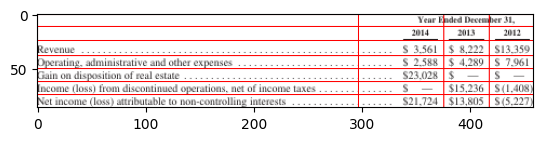

In [ ]:
i = 80000
print(f'idx : {i}')
data_detection = json.loads(structure_lines[i])
table_dict = table_dict_final(i)
file_name= data_detection['filename']
print(file_name)
pdf_filepath = data_fintabnet_path + "pdf/" + file_name
pdf_page = PdfFileReader(pdf_filepath).getPage(0)
pdf_shape = pdf_page.mediaBox
pdf_height = pdf_shape[3]-pdf_shape[1]
pdf_width = pdf_shape[2]-pdf_shape[0]
converted_images = convert_from_path(pdf_filepath, size=(pdf_width, pdf_height))
img = converted_images[0]
# print(pdf_height, pdf_width)
table_box = data_detection['bbox']
# print(f'1st : {table_box}')
# print(f'pdf_height {pdf_height}')
tl_x =              (table_box[0])
tl_y = float(pdf_height) - (table_box[3]) 
br_x =              (table_box[2])
br_y = float(pdf_height) - (table_box[1])
# print(tl_x, tl_y, br_x, br_y)
img_array = np.array(img)
page_image = Image.fromarray(img_array)
image_table_crop = page_image.crop((int(tl_x), int(tl_y), int(br_x), int(br_y)))
# plt.imshow(image_table_crop)
# plt.show()
num_rows = max([max(cell['row_nums']) for cell in table_dict['cells']]) + 1
num_columns = max([max(cell['column_nums']) for cell in table_dict['cells']]) + 1
row_dict, col_dict = get_row_col_cell(num_rows, num_columns, table_dict)
row_final = get_row_bbox_final(row_dict, image_table_crop)
col_final = get_col_bbox_final(col_dict, image_table_crop)


row_mid_line = get_row_bbox_midpoint(row_final , image_table_crop)
col_mid_line = get_col_bbox_midpoint(col_final , image_table_crop)
row_point_list = get_row_mid_pont(row_mid_line , image_table_crop)
col_point_list = get_col_mid_point(col_mid_line , image_table_crop)
bbox_cell_ori = get_bbox_cell(row_point_list,col_point_list)


final_matrix_row = get_matrix_row(table_dict, num_rows, num_columns)
final_matrix_col = get_matrix_col(table_dict, num_rows, num_columns)

img_test = Image.fromarray(np.array(image_table_crop))
draw = ImageDraw.Draw(img_test)

if (num_columns*num_rows) == len(bbox_cell_ori):
    print('TRUE')
else :
    print('FALSE')

for bbox_data in bbox_cell_ori:
    row_idx , col_idx , x1, y1, x2, y2 = bbox_data
    bbox = [x1 , y1 , x2, y2]
    draw.rectangle(bbox, outline="red", width=1)
plt.imshow(img_test)
print('/////////////// ROW //////////////')
print(final_matrix_row)
print('/////////////// COL //////////////')
print(final_matrix_col)

In [ ]:
i = 20000
print(f'idx : {i}')
data_detection = json.loads(structure_lines[i])
table_dict = table_dict_final(i)

idx : 20000


In [34]:
from IPython.core.display import display, HTML

In [ ]:
table_dict_html = gen_table_dict_for_html(table_dict['cells'])
html_table = generate_html_table(table_dict_html)   
display(HTML(html_table))

In [ ]:
type(html_table)

str

In [45]:
html_folder = "C:/Users/bom/Desktop/git/fintabnet_thongke/test_gt/html_code/"
image_folder = "C:/Users/bom/Desktop/git/fintabnet_thongke/test_gt/image/"

In [ ]:
i = 101
# print(f'idx : {i}')
data_detection = json.loads(structure_lines[i])
table_dict = table_dict_final(i)
file_name= data_detection['filename']
# print(file_name)
file_name_str = str(file_name[:-4]).replace('/','_')
table_id = data_detection['table_id']
file_name_str = file_name_str + '_' + str(table_id)
pdf_filepath = data_fintabnet_path + "pdf/" + file_name
pdf_page = PdfFileReader(pdf_filepath).getPage(0)
pdf_shape = pdf_page.mediaBox
pdf_height = pdf_shape[3]-pdf_shape[1]
pdf_width = pdf_shape[2]-pdf_shape[0]
converted_images = convert_from_path(pdf_filepath, size=(pdf_width, pdf_height))
img = converted_images[0]
# print(pdf_height, pdf_width)
table_box = data_detection['bbox']
# print(f'1st : {table_box}')
# print(f'pdf_height {pdf_height}')
tl_x =              (table_box[0])
tl_y = float(pdf_height) - (table_box[3]) 
br_x =              (table_box[2])
br_y = float(pdf_height) - (table_box[1])
# print(tl_x, tl_y, br_x, br_y)
img_array = np.array(img)
page_image = Image.fromarray(img_array)
image_table_crop = page_image.crop((int(tl_x), int(tl_y), int(br_x), int(br_y)))
# plt.imshow(image_table_crop)
# plt.show()
num_rows = max([max(cell['row_nums']) for cell in table_dict['cells']]) + 1
num_columns = max([max(cell['column_nums']) for cell in table_dict['cells']]) + 1
row_dict, col_dict = get_row_col_cell(num_rows, num_columns, table_dict)
row_final = get_row_bbox_final(row_dict, image_table_crop)
col_final = get_col_bbox_final(col_dict, image_table_crop)


row_mid_line = get_row_bbox_midpoint(row_final , image_table_crop)
col_mid_line = get_col_bbox_midpoint(col_final , image_table_crop)
row_point_list = get_row_mid_pont(row_mid_line , image_table_crop)
col_point_list = get_col_mid_point(col_mid_line , image_table_crop)
bbox_cell_ori = get_bbox_cell(row_point_list,col_point_list)


final_matrix_row = get_matrix_row(table_dict, num_rows, num_columns)
final_matrix_col = get_matrix_col(table_dict, num_rows, num_columns)

# img_test = Image.fromarray(np.array(image_table_crop))
# draw = ImageDraw.Draw(img_test)

########## save data html ################
html_file_name = html_folder + file_name_str + '.html'
with open(html_file_name, 'w') as f:
    table_dict_html = gen_table_dict_for_html(table_dict['cells'])
    html_table = generate_html_table(table_dict_html)   
    f.write(html_table)
    f.close()

###################################
############ save image ###############
file_name_image_save = image_folder + file_name_str + '.jpg'
image_table_crop.save(file_name_image_save)
###################################

idx : 101
HAL/2015/page_93.pdf


In [49]:
for i  in range(20000):
    try:
        # i = 101
        # print(f'idx : {i}')
        data_detection = json.loads(structure_lines[i])
        table_dict = table_dict_final(i)
        file_name= data_detection['filename']
        # print(file_name)
        file_name_str = str(file_name[:-4]).replace('/','_')
        table_id = data_detection['table_id']
        file_name_str = file_name_str + '_' + str(table_id)
        pdf_filepath = data_fintabnet_path + "pdf/" + file_name
        pdf_page = PdfFileReader(pdf_filepath).getPage(0)
        pdf_shape = pdf_page.mediaBox
        pdf_height = pdf_shape[3]-pdf_shape[1]
        pdf_width = pdf_shape[2]-pdf_shape[0]
        converted_images = convert_from_path(pdf_filepath, size=(pdf_width, pdf_height))
        img = converted_images[0]
        # print(pdf_height, pdf_width)
        table_box = data_detection['bbox']
        # print(f'1st : {table_box}')
        # print(f'pdf_height {pdf_height}')
        tl_x =              (table_box[0])
        tl_y = float(pdf_height) - (table_box[3]) 
        br_x =              (table_box[2])
        br_y = float(pdf_height) - (table_box[1])
        # print(tl_x, tl_y, br_x, br_y)
        img_array = np.array(img)
        page_image = Image.fromarray(img_array)
        image_table_crop = page_image.crop((int(tl_x), int(tl_y), int(br_x), int(br_y)))
        # plt.imshow(image_table_crop)
        # plt.show()
        num_rows = max([max(cell['row_nums']) for cell in table_dict['cells']]) + 1
        num_columns = max([max(cell['column_nums']) for cell in table_dict['cells']]) + 1
        row_dict, col_dict = get_row_col_cell(num_rows, num_columns, table_dict)
        row_final = get_row_bbox_final(row_dict, image_table_crop)
        col_final = get_col_bbox_final(col_dict, image_table_crop)


        row_mid_line = get_row_bbox_midpoint(row_final , image_table_crop)
        col_mid_line = get_col_bbox_midpoint(col_final , image_table_crop)
        row_point_list = get_row_mid_pont(row_mid_line , image_table_crop)
        col_point_list = get_col_mid_point(col_mid_line , image_table_crop)
        bbox_cell_ori = get_bbox_cell(row_point_list,col_point_list)


        final_matrix_row = get_matrix_row(table_dict, num_rows, num_columns)
        final_matrix_col = get_matrix_col(table_dict, num_rows, num_columns)

        # img_test = Image.fromarray(np.array(image_table_crop))
        # draw = ImageDraw.Draw(img_test)

        ########## save data html ################
        html_file_name = html_folder + file_name_str + '.html'
        with open(html_file_name, 'w') as f:
            table_dict_html = gen_table_dict_for_html(table_dict['cells'])
            html_table = generate_html_table(table_dict_html)   
            f.write(html_table)
            f.close()

        ###################################
        ############ save image ###############
        file_name_image_save = image_folder + file_name_str + '.jpg'
        image_table_crop.save(file_name_image_save)
        ###################################
    except:
        data_detection = json.loads(structure_lines[i])
        file_name_test= data_detection['filename']
        print(file_name_test)       

IndexError: list index out of range

In [42]:
with open(html_file_name, 'r') as file:
    html_content = file.read()

# Display HTML content
display(HTML(html_content))